In [1]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import trigauss
import mesh
import fem
import pyamg

In [2]:
pts, tris, boundaries = mesh.load_mesh('rectangle.msh')
pts = pts[:,:2]

A,B,D1,D2,qpts,qtris = fem.assemble_taylor_hood_matrices(pts, tris)

Loaded mesh with 613 vertices


In [3]:
print(len(pts))

613


In [4]:
def draw_triangles(points, tris):
    '''
    Plot linear triangles.
    '''
    for tri in tris:
        x,y = np.column_stack([
            points[tri[0]], points[tri[1]], points[tri[2]]
        ])
        plt.plot(x,y,'ko',markersize=2)
        x = np.append(x,x[0]); y = np.append(y,y[0])
        plt.plot(x,y,'k-')

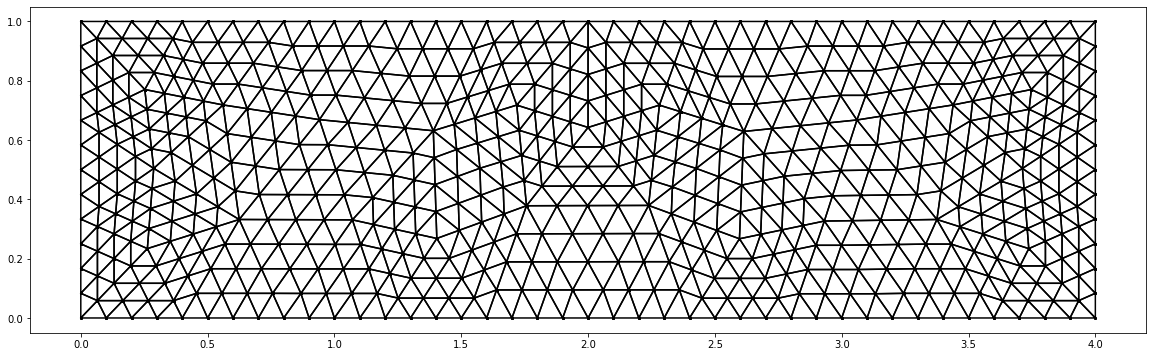

In [5]:
plt.figure(figsize=(20,6))
draw_triangles(pts,tris)

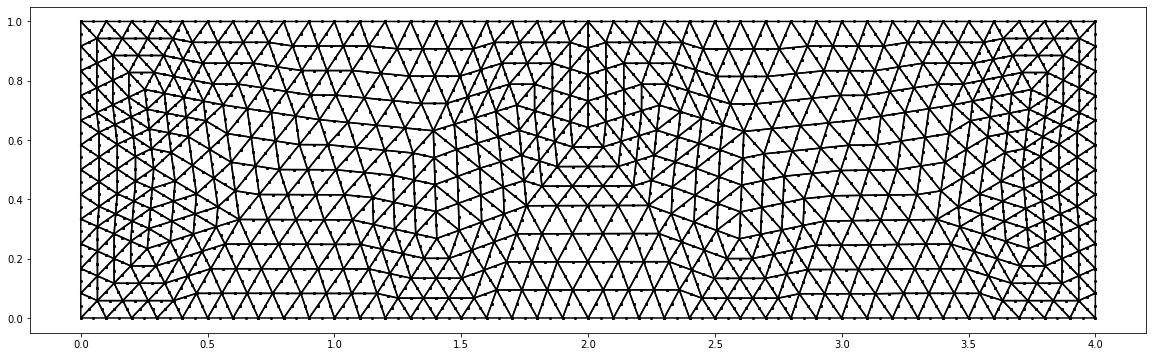

In [6]:
def draw_triangles_quad(points, tris):
    '''
    Plot quadratic triangles
    '''
    for tri in tris:
        x,y = np.column_stack([
            points[tri[0]], points[tri[3]], points[tri[1]], points[tri[4]], points[tri[2]], points[tri[5]]
        ])
        plt.plot(x,y,'ko',markersize=2)
        x = np.append(x,x[0]); y = np.append(y,y[0])
        plt.plot(x,y,'k-')

plt.figure(figsize=(20,6))
draw_triangles_quad(qpts, qtris)

In [7]:
from functools import reduce
def union_many(boundaries):
    return reduce(np.union1d, boundaries)

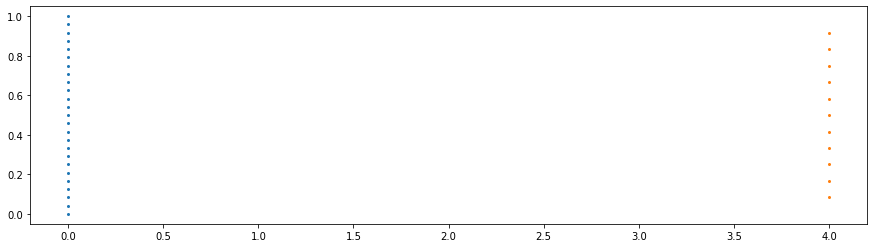

In [29]:
#boundaries[0] = circle
#boundaries[1] = left inlet
#boundaries[2] = bottom wall
#boundaries[3] = right wall
#boundaries[4] = top wall

def boundary_nodes(xy):
    x,y=xy
    if x==0:
        return True
    return False

def boundary_nodes_pressure(xy):
    x,y=xy
    if y==1:
        return False
    if y==0:
        return False
    if x==4:
        return True
    return False

dc_nodes = []
for i,q in enumerate(qpts):
    if boundary_nodes(q):
        dc_nodes.append(i)
dc_nodes = np.array(dc_nodes)

dc_nodes_p = []
for i,q in enumerate(pts):
    if boundary_nodes_pressure(q):
        dc_nodes_p.append(i)
dc_nodes_p = np.array(dc_nodes_p)

R = fem.create_restriction(A.shape[0], dc_nodes)
R_p = fem.create_restriction(D1.shape[0], dc_nodes_p)
plt.figure(figsize=(15,4))
plt.plot(qpts[dc_nodes][:,0], qpts[dc_nodes][:,1], 'o', markersize=2)
plt.plot(pts[dc_nodes_p][:,0], pts[dc_nodes_p][:,1], 'o', markersize=2)

In [30]:
def boundary_u_x(xy):
    x, y = xy
    if y==1 or y==0 or (x-2)**2 + (y-0.5)**2 <= 0.3**2:
        return 0
    elif x==0:
        return 1

def boundary_u_y(xy):
    return 0

def create_rhs(A, pts, boundary_nodes, boundary_function):
    boundary_values = np.apply_along_axis(boundary_function, 1, pts[boundary_nodes])
    rhs = np.zeros(A.shape[0])
    bcs = np.zeros(A.shape[0])
    Acsc = A.tocsc()
    
    for i, bc in enumerate(boundary_nodes):
        col = np.array(Acsc[:,bc].todense()).flatten()
        rhs -= col * boundary_values[i]
        bcs[bc] = boundary_values[i]
    
    return rhs, bcs

rhs_x, bcs_x = create_rhs(A, qpts, dc_nodes, boundary_u_x)
rhs_y, bcs_y = create_rhs(A, qpts, dc_nodes, boundary_u_y)

In [31]:
import scipy.interpolate as si
import matplotlib.colors as colors

def plot_soln_quad(points, triangles, u):
    x = np.linspace(np.min(points[:,0]), np.max(points[:,0]), 400)
    y = np.linspace(np.min(points[:,1]), np.max(points[:,1]), 100)
    xx, yy = np.meshgrid(x,y); xx=xx.flatten(); yy=yy.flatten()
    xi = np.row_stack([xx,yy])
    interpolated = si.griddata(points, u, xi.T, method='cubic')
    #domain = ((xx-2)**2 + (yy-0.5)**2) > (0.25)**2
    domain = xx >= 0
    plt.scatter(xx[domain], yy[domain], 5, interpolated[domain])

def plot_soln(points, triangles, u):
    plt.tripcolor(points[:,0], points[:,1], triangles, u, shading='gouraud')

In [32]:
Ah = R.T@A@R

Dx = D1@R
Dy = D2@R
Zh = None
Saddle = sp.bmat([
    [Ah,   Zh, -Dx.T],
    [Zh,   Ah, -Dy.T],
    [-Dx, -Dy,    Zh]
]).tocsr()

In [33]:
Ah.shape

(2320, 2320)

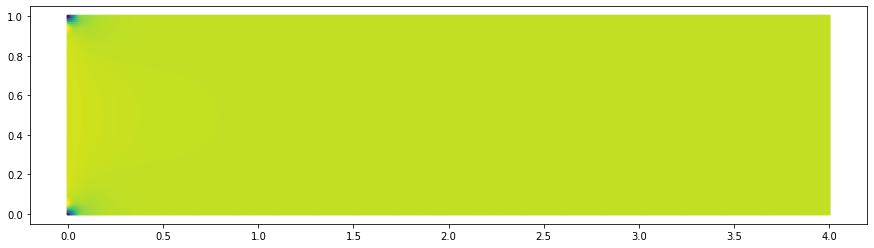

In [34]:
u_x = spla.cg(Ah, R.T@rhs_x)[0]
plt.figure(figsize=(15,4))
plot_soln_quad(qpts, qtris, R@u_x + bcs_x)

In [35]:
import time

In [36]:
def conjugate_gradient(A, b, res_tol=1e-4):
    # Based on implementation from
    # Iterative Methods for Sparse Linear Systems by Y. Saad
    x = np.zeros(A.shape[0])
    if la.norm(b) == 0:
        return x
    
    r = b
    p = r
    for i in range(A.shape[1]):
        Ap = A@p
        rjn = r@r
        alpha = rjn / (Ap@p)
        x = x + alpha*p
        r = r - alpha*Ap
        beta = (r@r)/rjn
        p = r + beta*p
        if (la.norm(r)/la.norm(b)) < res_tol:
            break
    return x

0.6797018051147461


Text(0.5, 1.0, 'Pressure')

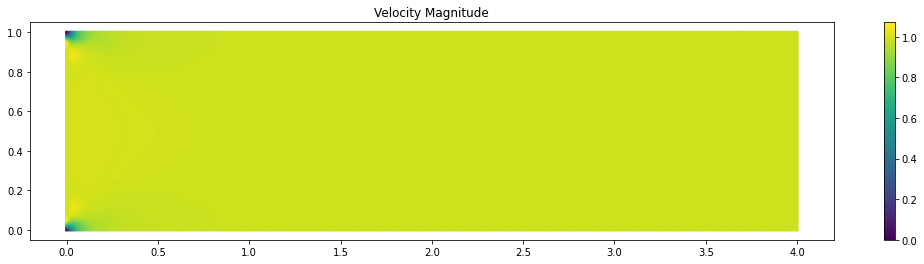

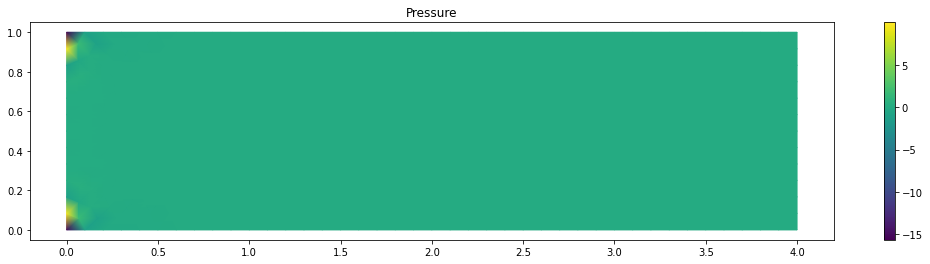

In [37]:
## Normal sparse solve ##

rhs_p = D1@bcs_x + D2@bcs_y

start_up = time.time()
up = conjugate_gradient(Saddle, np.hstack([R.T@rhs_x, R.T@rhs_y, rhs_p]), res_tol=1e-10)
end_up = time.time()
print(end_up-start_up)

s = (R.T@rhs_x).shape[0]
u_x = R@up[:s] + bcs_x
u_y = R@up[s:2*s] + bcs_y
p = up[2*s:]

plt.figure(figsize=(18,4))
plot_soln_quad(qpts, qtris, np.sqrt(u_x**2 + u_y**2))
plt.colorbar()
plt.title('Velocity Magnitude')

plt.figure(figsize=(18,4))
plot_soln(pts, tris, p)
plt.colorbar()
plt.title('Pressure')

uzawa solve 2.8694658279418945


Text(0.5, 1.0, 'Pressure')

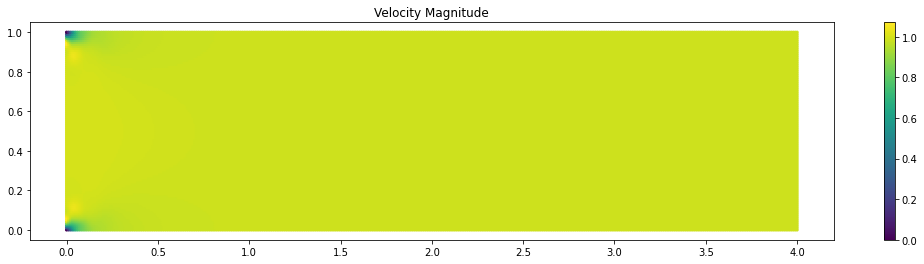

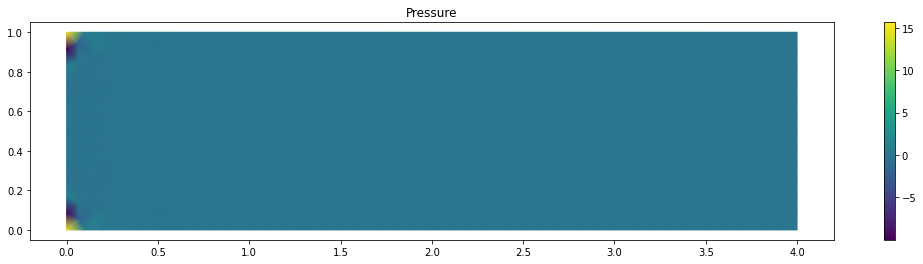

In [17]:
## Uzawa iteration #3

f = np.hstack([R.T@rhs_x, R.T@rhs_y])
g = -rhs_p
D = sp.bmat([[Dx.T],[Dy.T]])

pressure_size = Dx.shape[0]
velocity_size_1d = Ah.shape[0]
velocity_size_2d = 2*velocity_size_1d

def uzawa(b1, b2, res_tol=1e-10, amg_tol=1e-4):
    # S = D A^{-1} D^T
    x2 = np.zeros(pressure_size)
    x1 = AA_amg.solve(b1 - D@x2, tol=amg_tol)
    r2 = D.T@x1 - b2
    p2 = r2
    for i in range(AA.shape[1]):
        # Sp = D A^{-1} D^T p
        p1 = AA_amg.solve(D@p2)
        Sp = D.T@p1
        alpha = (r2@r2)/(Sp@p2)
        x2 = x2 + alpha*p2
        x1 = x1 - alpha*p1
        r_old = r2
        r2 = r2 - alpha*Sp
        beta = (r2@r2)/(r_old@r_old)
        p2 = r2 + beta * p2
        if la.norm(r2)/la.norm(b2) < res_tol:
            break
    return np.hstack([x1,x2])
    
AA = sp.block_diag([Ah,Ah]).tocsr()
AA_amg = pyamg.smoothed_aggregation_solver(AA)

start_p = time.time()
up = uzawa(f, g, res_tol=1e-8, amg_tol=1e-16)
end_p = time.time()
print('uzawa solve', end_p-start_p)

s = (R.T@rhs_x).shape[0]
u_x = R@up[:s] + bcs_x
u_y = R@up[s:2*s] + bcs_y
p = up[2*s:]

plt.figure(figsize=(18,4))
plot_soln_quad(qpts, qtris, np.sqrt(u_x**2 + u_y**2))
plt.colorbar()
plt.title('Velocity Magnitude')

plt.figure(figsize=(18,4))
plot_soln(pts, tris, p)
plt.colorbar()
plt.title('Pressure')

Text(0.5, 1.0, 'Y Velocity')

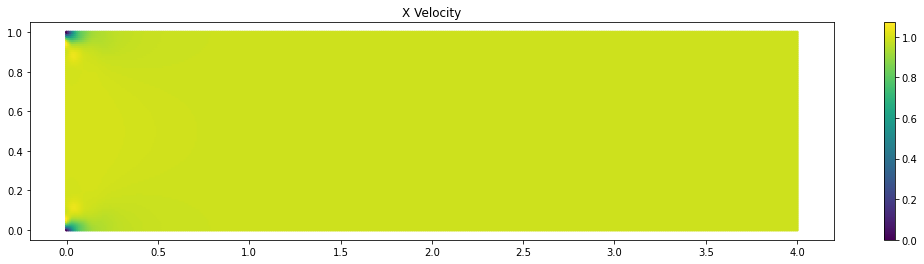

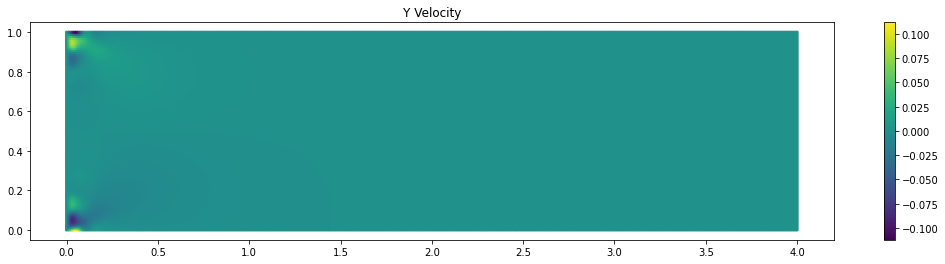

In [18]:
plt.figure(figsize=(18,4))
plot_soln_quad(qpts, qtris, u_x)
plt.colorbar()
plt.title('X Velocity')

plt.figure(figsize=(18,4))
plot_soln_quad(qpts, qtris, u_y)
plt.colorbar()
plt.title('Y Velocity')

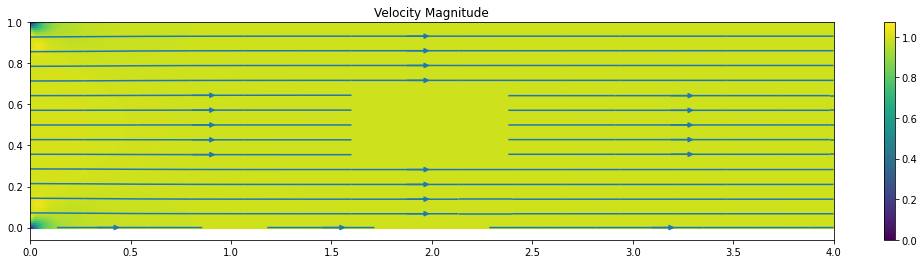

In [19]:
import matplotlib.tri as tri

def plot_streamlines(points, u_x, u_y):
    x = np.linspace(np.min(points[:,0]), np.max(points[:,0]), 500)
    y = np.linspace(np.min(points[:,1]), np.max(points[:,1]), 500)
    xx, yy = np.meshgrid(x,y);
    xi = np.row_stack([xx.flatten(),yy.flatten()])
    u_xi = si.griddata(points, u_x, xi.T, method='cubic')
    u_yi = si.griddata(points, u_y, xi.T, method='cubic')
    
    hole = ((xx-2)**2 + (yy-0.5)**2) <= (0.25)**2
    u_xi = u_xi.reshape(xx.shape)
    u_yi = u_yi.reshape(yy.shape)
    
    u_xi[hole] = 0
    u_yi[hole] = 0
    
    plt.streamplot(xx,yy,u_xi,u_yi,density=0.5)

plt.figure(figsize=(18,4))
plot_soln_quad(qpts, qtris, np.sqrt(u_x**2 + u_y**2))
plt.colorbar()
plt.title('Velocity Magnitude')
plot_streamlines(qpts, u_x, u_y)